## Dependencies 

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

import statsmodels.api as sm
import seaborn as sns
from math import sqrt

import pandas as pd
import numpy as np
from config import password


In [2]:
# Database dependencies
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

# Database credentials
DATABASES = {
    'finalproject':{
        'POSTGRES_ADDRESS' :'finalproject.c969jxlkzz2v.us-east-2.rds.amazonaws.com',
        'POSTGRES_PORT' : '5432',
        'POSTGRES_USERNAME' : "postgres",
        'POSTGRES_PASSWORD' : password,
        'POSTGRES_DBNAME' : 'housingdata',
    },
}

# Choose the database to use
db = DATABASES['finalproject']

# Connect to postgres
postgres_str = ('postgresql+psycopg2://{username}:{password}@{ipaddress}:{port}/{dbname}'
               .format(username= db['POSTGRES_USERNAME'],
                      password= db['POSTGRES_PASSWORD'],
                      ipaddress= db['POSTGRES_ADDRESS'],
                      port= db['POSTGRES_PORT'],
                      dbname= db['POSTGRES_DBNAME'])
               )

# Create an database engine instance
connection = create_engine(postgres_str)

## Load the datasets

In [3]:
df = pd.read_sql_table('final_table', connection)
df.head()

,city,zhvi,total_pop,med_income,med_age,male,female,race_w,race_aa,race_nat,...,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson,lat,long
0,Ladd,86540.17,1185.0,65972.0,42.9,587.0,598.0,1133.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,41.382535,-89.218975
1,Lake Bluff,459437.17,10003.0,107039.0,42.7,4642.0,5361.0,8616.0,151.0,62.0,...,0.0,0.0,1.0,0.0,7.0,36.0,0.0,0.0,42.278912,-87.834236
2,Lake Forest,808297.42,21131.0,171913.0,46.6,10472.0,10659.0,18890.0,520.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.258634,-87.840625
3,Lake Villa,208693.58,35286.0,96024.0,40.3,17646.0,17640.0,32294.0,900.0,131.0,...,1.0,4.0,0.0,4.0,3.0,29.0,1.0,0.0,42.416965,-88.073971
4,Lake Zurich,429947.17,42637.0,135146.0,42.0,21299.0,21338.0,36357.0,1008.0,145.0,...,0.0,1.0,1.0,3.0,18.0,238.0,3.0,0.0,42.196969,-88.093411


## Data preprocessing

In [4]:
clean_df = df.drop(['city','lat','long'],1)
clean_df.head()

,zhvi,total_pop,med_income,med_age,male,female,race_w,race_aa,race_nat,race_as,...,eth_hisp,eth_nonhisp,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson
0,86540.17,1185.0,65972.0,42.9,587.0,598.0,1133.0,0.0,0.0,7.0,...,83.0,1102.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0
1,459437.17,10003.0,107039.0,42.7,4642.0,5361.0,8616.0,151.0,62.0,1207.0,...,762.0,9241.0,0.0,0.0,1.0,0.0,7.0,36.0,0.0,0.0
2,808297.42,21131.0,171913.0,46.6,10472.0,10659.0,18890.0,520.0,94.0,1836.0,...,1013.0,20118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,208693.58,35286.0,96024.0,40.3,17646.0,17640.0,32294.0,900.0,131.0,1733.0,...,3137.0,32149.0,1.0,4.0,0.0,4.0,3.0,29.0,1.0,0.0
4,429947.17,42637.0,135146.0,42.0,21299.0,21338.0,36357.0,1008.0,145.0,5008.0,...,3441.0,39196.0,0.0,1.0,1.0,3.0,18.0,238.0,3.0,0.0


In [5]:
clean_df.describe()

,zhvi,total_pop,med_income,med_age,male,female,race_w,race_aa,race_nat,race_as,...,eth_hisp,eth_nonhisp,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson
count,9.790000e+02,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.00000,...,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,1.374120e+05,7628.810429,62588.514917,42.351034,3756.077061,3872.733369,6170.608401,772.398683,53.678888,422.29714,...,1054.550669,6574.259761,0.782431,4.395301,13.267620,25.935649,28.830439,149.924413,16.631256,1.105209
std,1.178790e+05,11587.889998,21145.745980,5.858168,5690.908651,5906.114219,8906.665564,2649.138961,103.762227,1262.54303,...,3744.702529,9435.356874,18.037414,58.060631,309.916187,493.154123,380.171509,2084.391414,324.717360,14.472814
min,1.852242e+04,58.000000,16023.000000,21.500000,28.000000,25.000000,58.000000,0.000000,0.000000,0.00000,...,0.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.388796e+04,819.500000,49696.000000,38.650000,405.000000,405.000000,792.000000,1.000000,0.000000,0.00000,...,7.000000,782.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.960942e+04,1995.000000,58289.000000,42.000000,1006.000000,1013.000000,1918.000000,22.000000,9.000000,11.00000,...,39.000000,1959.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.601418e+05,9741.500000,70160.000000,45.700000,4649.000000,4895.000000,7515.500000,242.500000,51.500000,121.00000,...,481.000000,8644.000000,0.000000,1.000000,0.000000,4.000000,8.000000,31.500000,2.000000,0.000000
max,1.360530e+06,83147.000000,212750.000000,63.500000,41769.000000,41378.000000,49654.000000,30695.000000,734.000000,9528.50000,...,74180.000000,52305.000000,563.000000,1798.000000,9684.000000,15312.000000,11686.000000,64695.000000,10132.000000,438.000000


In [6]:
# Split our preprocessed data into our features and target arrays
y = clean_df['zhvi']
X = clean_df.drop(['zhvi'], 1)

## Linear Regression

In [7]:
# Initiate Linear regression
models = [LinearRegression(), KNeighborsRegressor()]
for model in models:
    model.fit(X,y)
    predictions = model.predict(X)
    print(type(model).__name__)
    print(" MAE", mean_absolute_error(y,predictions))
    print(" RMSE", sqrt(mean_squared_error(y,predictions)))
    print(" R2", r2_score(y, predictions))


LinearRegression
 MAE 37883.936475374394
 RMSE 59778.91724508986
 R2 0.7425653716839009
KNeighborsRegressor
 MAE 26251.323563879847
 RMSE 42626.75627944521
 R2 0.8691012656405626


In [8]:
# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   zhvi   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     145.6
Date:                Sat, 13 Feb 2021   Prob (F-statistic):          1.16e-266
Time:                        11:33:58   Log-Likelihood:                -12157.
No. Observations:                 979   AIC:                         2.435e+04
Df Residuals:                     959   BIC:                         2.445e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.481e+05   1.64e+04     -9.024   

--------------A Multicollinearity plot---------------


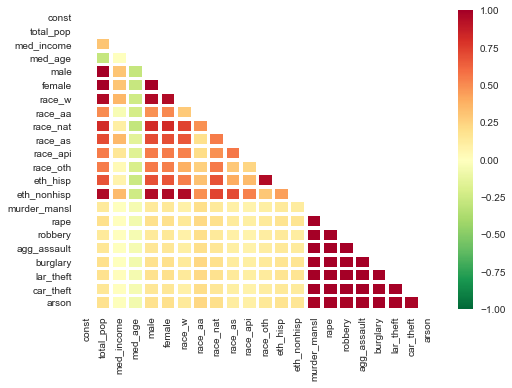

In [9]:
# Check for multicollinearity
corr_df = X.corr(method='pearson')
print("--------------A Multicollinearity plot---------------")

#Create a mask to display only the lower triangle of the matrix(since it mirrored around its top-left to bottom-right diagonal)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

#Create the heatmap using seaborn library
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0, mask= mask, linewidths=2.5)
# Show the plot. We reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

## Random Forest Regressor

In [10]:
# Split and Train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

In [11]:
# Create a StandardScaler instances
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
## Train the model
model_1 = RandomForestRegressor()
model_1.fit(X_train, y_train)

RandomForestRegressor()

In [13]:
# Predict
y_pred = model_1.predict(X_test)

In [14]:
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,89571.418100,83739.500000
1,141368.371900,131423.580000
2,167786.477100,162155.670000
3,78066.171500,91324.080000
4,72968.155200,81336.580000
5,102049.539800,136188.750000
6,89606.509400,88259.580000
7,246927.749938,229937.303333
8,76321.647600,52089.750000
9,79670.937400,111396.250000


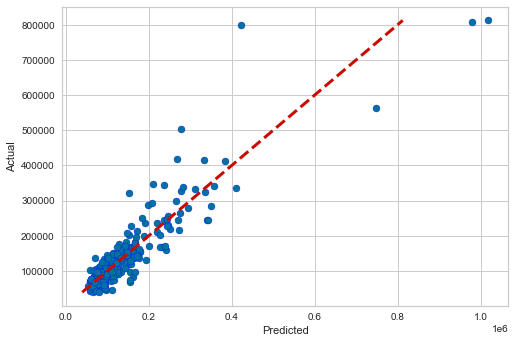

In [15]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [16]:
# Evaluate the model
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
rmse

46041.01581335725

In [17]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 26842.61026535757
Mean Squared Error: 2119775137.125812
Root Mean Squared Error: 46041.01581335725


Text(0.5, 0, 'Random Forest Feature Importance')

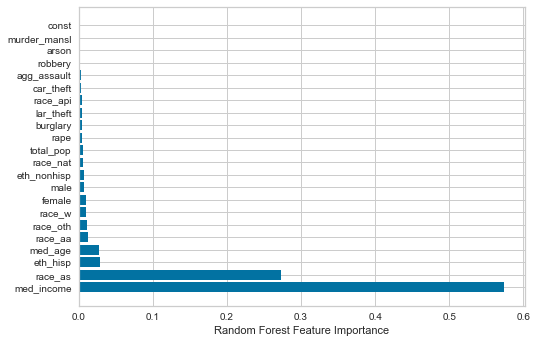

In [18]:
# List the features sorted in descending order by feature importance
features = (sorted(zip(model_1.feature_importances_, X.columns), reverse=True))

vals = [f for f,x in features]
names = [x for f,x in features]

plt.barh(names, vals)
plt.xlabel("Random Forest Feature Importance")

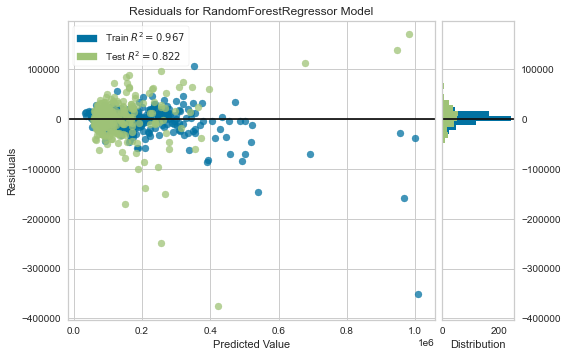

In [19]:
# Create the visualizer, fit, score, and show it
X, y = load_concrete()
viz = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test)

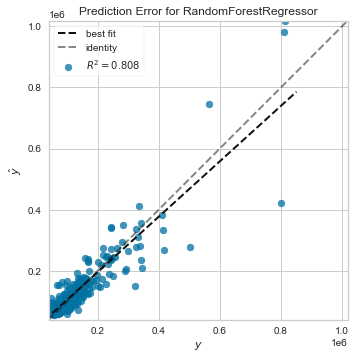

In [20]:
# Instantiate the linear model and visualizer
visualizer = prediction_error(model_1, X_train, y_train, X_test, y_test)